In [1]:
## This is the final version of Linear Regression & Quantile Linear Regression for cryptocurrency datasets

In [2]:
# import libraries 
import pandas as pd                                          # for reading dataset
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split         # for shuffling & splitting data

from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression            # for model fitting
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error # for model evaluation: https://scales.arabpsychology.com/stats/interpret-mape-values/

import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker

In [3]:
## Define function
def split_series(series, input_size, output_size, train_ratio, seed):
    # 1. split univariate series to input (X) and output (y)
    X, y = [], []  
    for i in range(len(series) - input_size - output_size + 1):
        X.append(series[i:i + input_size])                            # X = input e.g. [10, 20, 30]
        y.append(series[i + input_size:i + input_size + output_size]) # y = output e.g. [40, 50]
    # 2. shuffle batches and split into train/test
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, train_size = train_ratio, random_state=seed)
    
    return X_train, X_test, Y_train, Y_test

def split_data(data, input_size, output_size, train_ratio, seed):
    X, y = [], [] 
    total_size = input_size + output_size
    for i in range(len(data) - total_size + 1):
        X.append(features[i:i + input_size])                            
        y.append(target[i + input_size:i + total_size])        
    # 2. shuffle batches and split into train/test
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, train_size = train_ratio, random_state=seed)
    
    return X_train, X_test, Y_train, Y_test

# tilted loss function - crux of quantile regression
def tilted_loss(beta, X, y, tau):
    y_pred = np.dot(X, beta.reshape(X.shape[1], -1)) # multi step ahead version
    u = y - y_pred
    loss = np.where(u >= 0, tau * u, (tau - 1) * u)
    return np.sum(loss)

pm = "\u00B1"

In [4]:
# 1. Bitcoin (Univariate Linear regression)
Bitcoin = pd.read_csv('data/coin_Bitcoin.csv')
Close_Price = Bitcoin.iloc[:, 7].copy() # we are only interested in close price
Close_Price_reshaped = np.array(Close_Price).reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
Closed_Price_scaled = scaler.fit_transform(Close_Price_reshaped).flatten()

In [5]:
## Usage: define our parameters
input_size = 6         # 6 steps input 
output_size = 5        # 5 steps output (defined such that we can compare our results with related work)
train_ratio = 0.8
seed = 5925
num_experiments = 30   # ensure result is consistent

rmse, mae, mape = [], [], []
rmse_steps = [[] for _ in range(output_size)]
mae_steps = [[] for _ in range(output_size)]
mape_steps = [[] for _ in range(output_size)]

In [6]:
for i in range(num_experiments):
    X_train, X_test, y_train, y_test = split_series(Closed_Price_scaled, input_size, output_size, train_ratio, seed)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse.append(np.sqrt(mse))
    
    for step in range(output_size):
        mse_step = mean_squared_error(y_pred[step], y_test[step])
        rmse_steps[step].append(np.sqrt(mse_step))

    # Inverse Transform
    predicted_values = scaler.inverse_transform(y_pred)
    actual_values = scaler.inverse_transform(y_test)
    
    mae.append(mean_absolute_error(actual_values, predicted_values))
    mape.append(mean_absolute_percentage_error(actual_values, predicted_values))
    
    actual_values_steps = list(zip(*actual_values))
    predicted_values_steps = list(zip(*predicted_values))
    
    for step in range(output_size):
        mae_steps[step].append(mean_absolute_error(actual_values_steps[step], predicted_values_steps[step]))
        mape_steps[step].append(mean_absolute_percentage_error(actual_values_steps[step], predicted_values_steps[step]))

    seed += 1

print(f"Univariate Linear Regression: After {num_experiments} experimental runs, here are the results:")
print(f"Across {output_size} predictive time steps, " +
      f"Avg RMSE: {np.mean(rmse):.4f} {pm} {np.std(rmse):.4f}, " +
      f"Avg MAE: {np.mean(mae):.2f} {pm} {np.std(mae):.2f}, " +
      f"Avg MAPE: {np.mean(mape)*100:.3f}% {pm} {np.std(mape)*100:.3f}%")
for step in range(output_size):
    print(
        f"At time step {step + 1}, "
        f"Avg RMSE: {np.mean(rmse_steps[step]):.4f} {pm} {np.std(rmse_steps[step]):.4f}, "
        f"Avg MAE: {np.mean(mae_steps[step]):.2f} {pm} {np.std(mae_steps[step]):.2f}, "
        f"Avg MAPE: {np.mean(mape_steps[step]) * 100:.3f}% {pm} {np.std(mape_steps[step]) * 100:.3f}%"
    )

Univariate Linear Regression: After 30 experimental runs, here are the results:
Across 5 predictive time steps, Avg RMSE: 0.0157 ± 0.0011, Avg MAE: 375.81 ± 25.56, Avg MAPE: 9.505% ± 1.232%
At time step 1, Avg RMSE: 0.0068 ± 0.0105, Avg MAE: 207.34 ± 20.24, Avg MAPE: 4.020% ± 0.737%
At time step 2, Avg RMSE: 0.0076 ± 0.0185, Avg MAE: 305.26 ± 25.90, Avg MAPE: 6.604% ± 0.981%
At time step 3, Avg RMSE: 0.0076 ± 0.0149, Avg MAE: 389.86 ± 29.61, Avg MAPE: 9.614% ± 1.393%
At time step 4, Avg RMSE: 0.0062 ± 0.0110, Avg MAE: 458.63 ± 31.14, Avg MAPE: 12.253% ± 1.592%
At time step 5, Avg RMSE: 0.0029 ± 0.0040, Avg MAE: 517.95 ± 36.95, Avg MAPE: 15.034% ± 1.890%


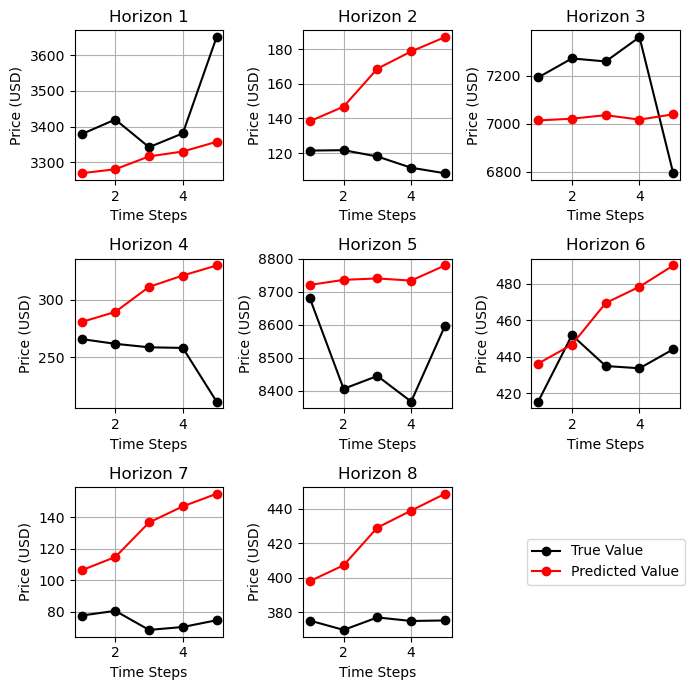

In [7]:
time_steps = list(range(1, output_size + 1))

fig, axs = plt.subplots(3, 3, figsize=(7, 7))  # Adjusted figure size for better spacing
axs = axs.flatten()
for i in range(8):  # Only plot the first 8 graphs
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, predicted_values[i], marker='o', linestyle='-', color='red', label='Predicted Value')
    ax.set_title(f'Horizon {i+1}')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Price (USD)')
    ax.grid(True)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(2))  # Ensure x-axis only displays integers

# Remove the 9th subplot
fig.delaxes(axs[8])
# Add legend in the 9th subplot's space
axs[8] = fig.add_subplot(3, 3, 9)
axs[8].axis('off')  # Hide the axes for the legend subplot
axs[8].legend(handles=[axs[0].lines[0], axs[0].lines[1]], loc='center')  # Center the legend

# Adjust layout
plt.tight_layout()
plt.show()

In [8]:
# 2. Bitcoin (Univariate Quantile Linear regression)
## Usage: define our parameters
input_size = 6         # 6 steps input 
output_size = 5        # 5 steps output (defined such that we can compare our results with related work)
train_ratio = 0.8
seed = 5925
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
num_experiments = 30    # default: 30 (change to lower value for less intensive runs)

rmse, mae, mape = [], [], []
quantile_rmse = {q: [] for q in quantiles}
rmse_steps = [[] for _ in range(output_size)]
mae_steps = [[] for _ in range(output_size)]
mape_steps = [[] for _ in range(output_size)]

In [9]:
for i in range(num_experiments):
    X_train, X_test, y_train, y_test = split_series(Closed_Price_scaled, input_size, output_size, train_ratio, seed)
    X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

    results = {q: None for q in quantiles}

    for q in quantiles:
        initial_beta = np.zeros((X_train.shape[1], output_size)).flatten()
        result = minimize(tilted_loss, initial_beta, args=(X_train, y_train, q), method='BFGS')
        beta_hat = result.x.reshape(X_train.shape[1], output_size)
        y_pred_test = np.dot(X_test, beta_hat)
        results[q] = y_pred_test

    mse = mean_squared_error(results[0.5], y_test)
    rmse.append(np.sqrt(mse))
    
    for step in range(output_size):
        mse_step = mean_squared_error(results[0.5][step], y_test[step])
        rmse_steps[step].append(np.sqrt(mse_step))

    for q in quantiles:
        mse_quantile = mean_squared_error(results[q], y_test)
        quantile_rmse[q].append(np.sqrt(mse_quantile))

    # Inverse Transform
    predicted_values = scaler.inverse_transform(results[0.5])
    actual_values = scaler.inverse_transform(y_test)
    
    mae.append(mean_absolute_error(actual_values, predicted_values))
    mape.append(mean_absolute_percentage_error(actual_values, predicted_values))
    
    actual_values_steps = list(zip(*actual_values))
    predicted_values_steps = list(zip(*predicted_values))
    
    for step in range(output_size):
        mae_steps[step].append(mean_absolute_error(actual_values_steps[step], predicted_values_steps[step]))
        mape_steps[step].append(mean_absolute_percentage_error(actual_values_steps[step], predicted_values_steps[step]))

    # print(f"Exp {i+1} on test set: RMSE: {rmse[i]:.4f}, MAE: {mae[i]:.2f}, MAPE: {mape[i]:.4f}")
    seed += 1

print(f"Univariate Quantile Linear Regression: After {num_experiments} experimental runs, here are the results:")
print(f"Across {output_size} predictive time steps, " +
      f"Avg RMSE: {np.mean(rmse):.4f} {pm} {np.std(rmse):.4f}, " +
      f"Avg MAE: {np.mean(mae):.2f} {pm} {np.std(mae):.2f}, " +
      f"Avg MAPE: {np.mean(mape)*100:.3f}% {pm} {np.std(mape)*100:.3f}%")
for step in range(output_size):
    print(
        f"At time step {step + 1}, "
        f"Avg RMSE: {np.mean(rmse_steps[step]):.4f} {pm} {np.std(rmse_steps[step]):.4f}, "
        f"Avg MAE: {np.mean(mae_steps[step]):.2f} {pm} {np.std(mae_steps[step]):.2f}, "
        f"Avg MAPE: {np.mean(mape_steps[step]) * 100:.3f}% {pm} {np.std(mape_steps[step]) * 100:.3f}%"
    )
print("--------------------------------------------")
for q in quantiles:
    print(f"At Quantile {q}, it has Avg RMSE: {np.mean(quantile_rmse[q]):.4f} {pm} {np.std(quantile_rmse[q]):.4f}")

Univariate Quantile Linear Regression: After 30 experimental runs, here are the results:
Across 5 predictive time steps, Avg RMSE: 0.0156 ± 0.0011, Avg MAE: 361.06 ± 26.60, Avg MAPE: 4.820% ± 0.165%
At time step 1, Avg RMSE: 0.0067 ± 0.0103, Avg MAE: 202.02 ± 20.02, Avg MAPE: 2.679% ± 0.087%
At time step 2, Avg RMSE: 0.0070 ± 0.0172, Avg MAE: 296.90 ± 26.04, Avg MAPE: 3.968% ± 0.165%
At time step 3, Avg RMSE: 0.0075 ± 0.0152, Avg MAE: 375.85 ± 30.52, Avg MAPE: 4.967% ± 0.203%
At time step 4, Avg RMSE: 0.0058 ± 0.0099, Avg MAE: 439.50 ± 33.75, Avg MAPE: 5.829% ± 0.234%
At time step 5, Avg RMSE: 0.0027 ± 0.0044, Avg MAE: 491.03 ± 38.50, Avg MAPE: 6.657% ± 0.240%
--------------------------------------------
At Quantile 0.05, it has Avg RMSE: 0.0287 ± 0.0023
At Quantile 0.25, it has Avg RMSE: 0.0175 ± 0.0013
At Quantile 0.5, it has Avg RMSE: 0.0156 ± 0.0011
At Quantile 0.75, it has Avg RMSE: 0.0182 ± 0.0017
At Quantile 0.95, it has Avg RMSE: 0.0305 ± 0.0026


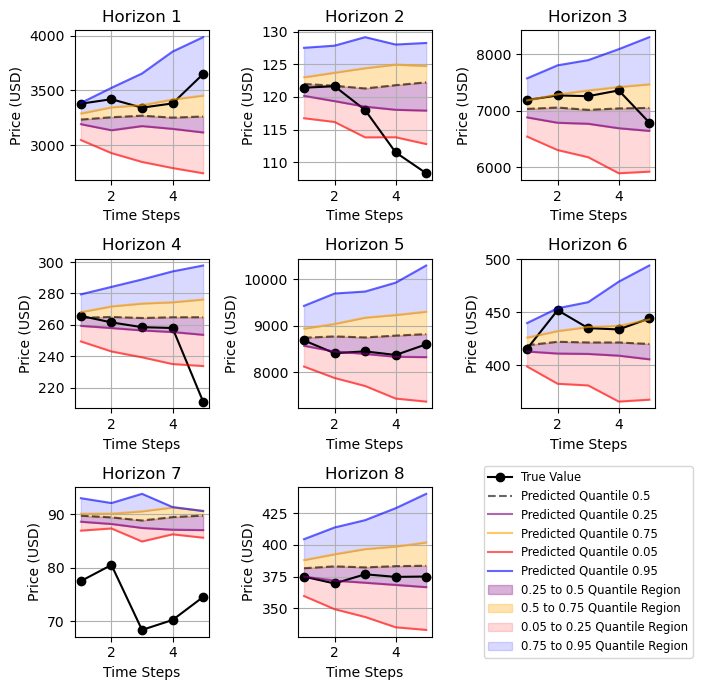

In [10]:
time_steps = list(range(1, output_size + 1))
fig, axs = plt.subplots(3, 3, figsize=(7, 7))
axs = axs.flatten()
for i in range(8):
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, scaler.inverse_transform(results[0.5])[i], linestyle='--', color='black', label='Predicted Quantile 0.5', alpha=0.6)
    ax.plot(time_steps, scaler.inverse_transform(results[0.25])[i], linestyle='-', color='purple', label='Predicted Quantile 0.25', alpha=0.6)
    ax.plot(time_steps, scaler.inverse_transform(results[0.75])[i], linestyle='-', color='orange', label='Predicted Quantile 0.75', alpha=0.6)
    ax.plot(time_steps, scaler.inverse_transform(results[0.05])[i], linestyle='-', color='red', label='Predicted Quantile 0.05', alpha=0.6)
    ax.plot(time_steps, scaler.inverse_transform(results[0.95])[i], linestyle='-', color='blue', label='Predicted Quantile 0.95', alpha=0.6)

    # Highlight regions between quantiles
    ax.fill_between(time_steps, scaler.inverse_transform(results[0.25])[i], scaler.inverse_transform(results[0.5])[i], color='purple', alpha=0.3, label='0.25 to 0.5 Quantile Region')
    ax.fill_between(time_steps, scaler.inverse_transform(results[0.5])[i], scaler.inverse_transform(results[0.75])[i], color='orange', alpha=0.3, label='0.5 to 0.75 Quantile Region')
    ax.fill_between(time_steps, scaler.inverse_transform(results[0.05])[i], scaler.inverse_transform(results[0.25])[i], color='red', alpha=0.15, label='0.05 to 0.25 Quantile Region')
    ax.fill_between(time_steps, scaler.inverse_transform(results[0.75])[i], scaler.inverse_transform(results[0.95])[i], color='blue', alpha=0.15, label='0.75 to 0.95 Quantile Region')

    ax.set_title(f'Horizon {i+1}')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Price (USD)')
    ax.grid(True)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(2))  # Ensure x-axis only displays integers

handles, labels = axs[0].get_legend_handles_labels()

# Remove the 9th subplot
fig.delaxes(axs[8])
# Add legend in the 9th subplot's space
axs[8] = fig.add_subplot(3, 3, 9)
axs[8].axis('off')  # Hide the axes for the legend subplot
axs[8].legend(handles=handles, labels=labels, loc='center', fontsize='small') 


plt.tight_layout()
plt.show()

In [11]:
# Model seems to struggle for lower values

In [12]:
# 3. Bitcoin (Multivariate Linear regression)
# We will include all features here but note that different combinations of features will yield different results
# Excluding some features may optimise the model - feature selection (can write in discussion)
data = Bitcoin.iloc[:, 4:]
features = data[['High', 'Low', 'Open', 'Close', 'Volume', 'Marketcap']]
features = MinMaxScaler().fit_transform(features) # normalise input
target = data['Close']
target_reshaped = np.array(target).reshape(-1, 1) # normalise output
scaler = MinMaxScaler(feature_range=(0, 1))
target = scaler.fit_transform(target_reshaped).flatten()

In [13]:
input_size = 6         # 6 steps input 
output_size = 5        # 5 steps output (defined such that we can compare our results with related work)
train_ratio = 0.8
seed = 5925
num_experiments = 30   # ensure result is consistent

rmse, mae, mape = [], [], []
rmse_steps = [[] for _ in range(output_size)]
mae_steps = [[] for _ in range(output_size)]
mape_steps = [[] for _ in range(output_size)]

In [14]:
for i in range(num_experiments):
    X_train, X_test, y_train, y_test = split_data(data, input_size, output_size, train_ratio, seed)
    X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)
    X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
    X_test_reshaped = X_test.reshape(X_test.shape[0], -1)
    model = LinearRegression()
    model.fit(X_train_reshaped, y_train)
    y_pred = model.predict(X_test_reshaped)

    mse = mean_squared_error(y_test, y_pred)
    rmse.append(np.sqrt(mse))
    
    for step in range(output_size):
        mse_step = mean_squared_error(y_pred[step], y_test[step])
        rmse_steps[step].append(np.sqrt(mse_step))

    # Inverse Transform
    predicted_values = scaler.inverse_transform(y_pred)
    actual_values = scaler.inverse_transform(y_test)
    
    mae.append(mean_absolute_error(actual_values, predicted_values))
    mape.append(mean_absolute_percentage_error(actual_values, predicted_values))
    
    actual_values_steps = list(zip(*actual_values))
    predicted_values_steps = list(zip(*predicted_values))
    
    for step in range(output_size):
        mae_steps[step].append(mean_absolute_error(actual_values_steps[step], predicted_values_steps[step]))
        mape_steps[step].append(mean_absolute_percentage_error(actual_values_steps[step], predicted_values_steps[step]))

    # print(f"Exp {i+1} on test set: RMSE: {rmse[i]:.4f}, MAE: {mae[i]:.2f}, MAPE: {mape[i]:.4f}")
    seed += 1

print(f"Multivariate Linear Regression: After {num_experiments} experimental runs, here are the results:")
print(f"Across {output_size} predictive time steps, " +
      f"Avg RMSE: {np.mean(rmse):.4f} {pm} {np.std(rmse):.4f}, " +
      f"Avg MAE: {np.mean(mae):.2f} {pm} {np.std(mae):.2f}, " +
      f"Avg MAPE: {np.mean(mape)*100:.3f}% {pm} {np.std(mape)*100:.3f}%")
for step in range(output_size):
    print(
        f"At time step {step + 1}, "
        f"Avg RMSE: {np.mean(rmse_steps[step]):.4f} {pm} {np.std(rmse_steps[step]):.4f}, "
        f"Avg MAE: {np.mean(mae_steps[step]):.2f} {pm} {np.std(mae_steps[step]):.2f}, "
        f"Avg MAPE: {np.mean(mape_steps[step]) * 100:.3f}% {pm} {np.std(mape_steps[step]) * 100:.3f}%"
    )

Multivariate Linear Regression: After 30 experimental runs, here are the results:
Across 5 predictive time steps, Avg RMSE: 0.0173 ± 0.0014, Avg MAE: 398.77 ± 31.70, Avg MAPE: 7.312% ± 1.067%
At time step 1, Avg RMSE: 0.0066 ± 0.0101, Avg MAE: 224.95 ± 22.52, Avg MAPE: 3.865% ± 0.563%
At time step 2, Avg RMSE: 0.0079 ± 0.0185, Avg MAE: 326.49 ± 32.38, Avg MAPE: 5.603% ± 0.901%
At time step 3, Avg RMSE: 0.0069 ± 0.0126, Avg MAE: 411.69 ± 34.68, Avg MAPE: 7.168% ± 1.059%
At time step 4, Avg RMSE: 0.0064 ± 0.0123, Avg MAE: 481.51 ± 36.93, Avg MAPE: 8.735% ± 1.459%
At time step 5, Avg RMSE: 0.0027 ± 0.0042, Avg MAE: 549.23 ± 45.69, Avg MAPE: 11.191% ± 1.774%


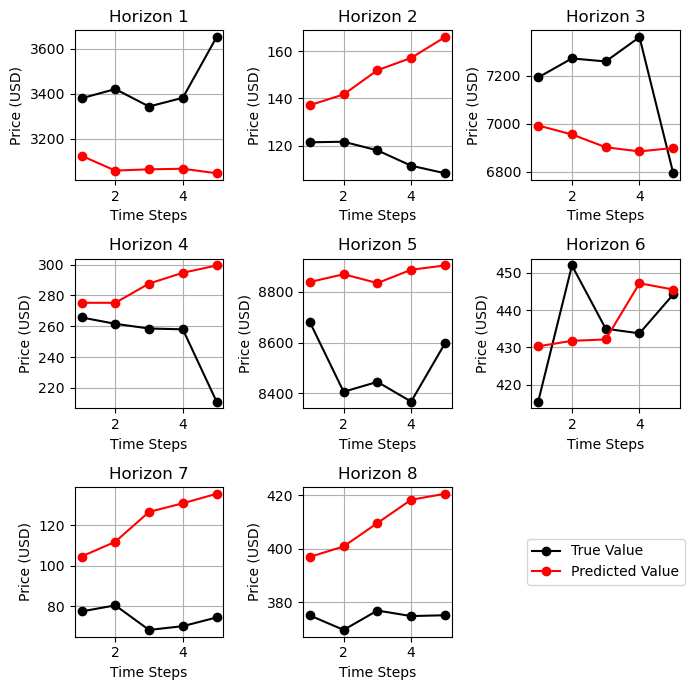

In [15]:
time_steps = list(range(1, output_size + 1))

fig, axs = plt.subplots(3, 3, figsize=(7, 7))  # Adjusted figure size for better spacing
axs = axs.flatten()
for i in range(8):  # Only plot the first 8 graphs
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, predicted_values[i], marker='o', linestyle='-', color='red', label='Predicted Value')
    ax.set_title(f'Horizon {i+1}')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Price (USD)')
    ax.grid(True)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(2))  # Ensure x-axis only displays integers

# Remove the 9th subplot
fig.delaxes(axs[8])
# Add legend in the 9th subplot's space
axs[8] = fig.add_subplot(3, 3, 9)
axs[8].axis('off')  # Hide the axes for the legend subplot
axs[8].legend(handles=[axs[0].lines[0], axs[0].lines[1]], loc='center')  # Center the legend

# Adjust layout
plt.tight_layout()
plt.show()

In [16]:
# 4. Bitcoin (Multivariate Quantile Linear Regression)
data = Bitcoin.iloc[:, 4:]
features = data[['High', 'Low', 'Open', 'Close']]
features = MinMaxScaler().fit_transform(features) # normalise input
target = data['Close']
target_reshaped = np.array(target).reshape(-1, 1) # normalise output
scaler = MinMaxScaler(feature_range=(0, 1))
target = scaler.fit_transform(target_reshaped).flatten()

num_experiments = 30   # default: 30
seed = 5925
input_size = 6        
output_size = 5       
train_ratio = 0.8

rmse = []
rmse_005 = [] # steps ahead rmse values across different quantiles
rmse_025 = []
rmse_050 = []
rmse_075 = []
rmse_095 = []
rmse_1 = [] # steps ahead rmse values across different experiments - median (0.5)
rmse_2 = []
rmse_3 = []
rmse_4 = []
rmse_5 = []

mae = []
mae_1 = []
mae_2 = []
mae_3 = []
mae_4 = []
mae_5 = []
mape = []
mape_1 = []
mape_2 = []
mape_3 = []
mape_4 = []
mape_5 = []

In [17]:
for exp in range(num_experiments):
    
    X_train, X_test, y_train, y_test = split_data(data, input_size, output_size, train_ratio, seed)
    X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)
    X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
    X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

    quantile = [0.05, 0.25, 0.5, 0.75, 0.95]

    # Use a dictionary to store the results
    results = {
        0.05: [],
        0.25: [],
        0.5:  [],
        0.75: [],
        0.95: []
    }
    
    for i in quantile:
        initial_beta = np.zeros((X_train.shape[1] * X_train.shape[2], output_size)).flatten()
        result = minimize(tilted_loss, initial_beta, args=(X_train_reshaped, y_train, i), method = 'BFGS')
        beta_hat = result.x.reshape((X_train_reshaped.shape[1], output_size))
        y_pred_test = np.dot(X_test_reshaped, beta_hat)
        results[i] = y_pred_test

    mse = mean_squared_error(results[0.5], y_test)
    rmse.append(np.sqrt(mse))

    pred_1 = results[0.5][:, 0] # prediction at future time step = 1 (Normalised)
    pred_2 = results[0.5][:, 1] 
    pred_3 = results[0.5][:, 2]
    pred_4 = results[0.5][:, 3]
    pred_5 = results[0.5][:, 4]
    
    actual_1 = y_test[:, 0]
    actual_2 = y_test[:, 1]
    actual_3 = y_test[:, 2]
    actual_4 = y_test[:, 3]
    actual_5 = y_test[:, 4]
    
    # Quantile Average RMSE across 3 steps
    mse_005 = mean_squared_error(results[0.05], y_test)
    mse_025 = mean_squared_error(results[0.25], y_test)
    mse_050 = mean_squared_error(results[0.5], y_test)
    mse_075 = mean_squared_error(results[0.75], y_test)
    mse_095 = mean_squared_error(results[0.95], y_test)
    rmse_005.append(np.sqrt(mse_005))
    rmse_025.append(np.sqrt(mse_025))
    rmse_050.append(np.sqrt(mse_050))
    rmse_075.append(np.sqrt(mse_075))
    rmse_095.append(np.sqrt(mse_095))

    # Steps Ahead RMSE: only interested in prediction (median: 0.5)
    mse_1 = mean_squared_error(pred_1, actual_1)
    mse_2 = mean_squared_error(pred_2, actual_2)
    mse_3 = mean_squared_error(pred_3, actual_3)
    mse_4 = mean_squared_error(pred_4, actual_4)
    mse_5 = mean_squared_error(pred_5, actual_5)
    rmse_1.append(np.sqrt(mse_1))
    rmse_2.append(np.sqrt(mse_2))
    rmse_3.append(np.sqrt(mse_3))
    rmse_4.append(np.sqrt(mse_4))
    rmse_5.append(np.sqrt(mse_5))
    
    # Inverse Transform
    predicted_values = scaler.inverse_transform(results[0.5])
    predicted_values_1 = predicted_values[:, 0] # prediction at future time step = 1 (Inverse Transformed)
    predicted_values_2 = predicted_values[:, 1]
    predicted_values_3 = predicted_values[:, 2]
    predicted_values_4 = predicted_values[:, 3]
    predicted_values_5 = predicted_values[:, 4]

    actual_values = scaler.inverse_transform(y_test)
    actual_values_1 = actual_values[:, 0]
    actual_values_2 = actual_values[:, 1]
    actual_values_3 = actual_values[:, 2]
    actual_values_4 = actual_values[:, 3]
    actual_values_5 = actual_values[:, 4]

    mae.append(mean_absolute_error(actual_values, predicted_values))
    # Individual time steps
    mae_1.append(mean_absolute_error(actual_values_1, predicted_values_1))
    mae_2.append(mean_absolute_error(actual_values_2, predicted_values_2))
    mae_3.append(mean_absolute_error(actual_values_3, predicted_values_3))
    mae_4.append(mean_absolute_error(actual_values_4, predicted_values_4))
    mae_5.append(mean_absolute_error(actual_values_5, predicted_values_5))
    
    mape.append(mean_absolute_percentage_error(actual_values, predicted_values))
    # Individual time steps
    mape_1.append(mean_absolute_percentage_error(actual_values_1, predicted_values_1))
    mape_2.append(mean_absolute_percentage_error(actual_values_2, predicted_values_2))
    mape_3.append(mean_absolute_percentage_error(actual_values_3, predicted_values_3))
    mape_4.append(mean_absolute_percentage_error(actual_values_4, predicted_values_4))
    mape_5.append(mean_absolute_percentage_error(actual_values_5, predicted_values_5))

    # print(f"Exp {exp+1} on test set: RMSE: {rmse[exp]:.4f}, MAE: {mae[exp]:.2f}, MAPE: {mape[exp]:.4f}")
    print(f"Experiment {exp+1}/{num_experiments} done")
    seed += 1

print(f"Multivariate Quantile Linear Regression: After {num_experiments} experimental runs, here are the results:")
print(f"Across {output_size} predictive time steps, " +
      f"Avg RMSE: {np.mean(rmse):.4f} {pm} {np.std(rmse):.4f}, " +
      f"Avg MAE: {np.mean(mae):.2f} {pm} {np.std(mae):.2f}, " +
      f"Avg MAPE: {np.mean(mape)*100:.3f}% {pm} {np.std(mape)*100:.3f}%")
print(f"At time step 1, Avg RMSE: {np.mean(rmse_1):.4f} {pm} {np.std(rmse_1):.4f}, Avg MAE: {np.mean(mae_1):.2f} {pm} {np.std(mae_1):.2f}, Avg MAPE: {np.mean(mape_1)*100:.3f}% {pm} {np.std(mape_1)*100:.3f}%")
print(f"At time step 2, Avg RMSE: {np.mean(rmse_2):.4f} {pm} {np.std(rmse_2):.4f}, Avg MAE: {np.mean(mae_2):.2f} {pm} {np.std(mae_2):.2f}, Avg MAPE: {np.mean(mape_2)*100:.3f}% {pm} {np.std(mape_2)*100:.3f}%")
print(f"At time step 3, Avg RMSE: {np.mean(rmse_3):.4f} {pm} {np.std(rmse_3):.4f}, Avg MAE: {np.mean(mae_3):.2f} {pm} {np.std(mae_3):.2f}, Avg MAPE: {np.mean(mape_3)*100:.3f}% {pm} {np.std(mape_3)*100:.3f}%")
print(f"At time step 4, Avg RMSE: {np.mean(rmse_4):.4f} {pm} {np.std(rmse_4):.4f}, Avg MAE: {np.mean(mae_4):.2f} {pm} {np.std(mae_4):.2f}, Avg MAPE: {np.mean(mape_4)*100:.3f}% {pm} {np.std(mape_4)*100:.3f}%")
print(f"At time step 5, Avg RMSE: {np.mean(rmse_5):.4f} {pm} {np.std(rmse_5):.4f}, Avg MAE: {np.mean(mae_5):.2f} {pm} {np.std(mae_5):.2f}, Avg MAPE: {np.mean(mape_5)*100:.3f}% {pm} {np.std(mape_5)*100:.3f}%")
print("--------------------------------------------")
print(f"At Quantile 0.05, it has Avg RMSE: {np.mean(rmse_005):.4f} {pm} {np.std(rmse_005):.4f}")
print(f"At Quantile 0.25, it has Avg RMSE: {np.mean(rmse_025):.4f} {pm} {np.std(rmse_025):.4f}")
print(f"At Quantile 0.50, it has Avg RMSE: {np.mean(rmse_050):.4f} {pm} {np.std(rmse_050):.4f}")
print(f"At Quantile 0.75, it has Avg RMSE: {np.mean(rmse_075):.4f} {pm} {np.std(rmse_075):.4f}")
print(f"At Quantile 0.95, it has Avg RMSE: {np.mean(rmse_095):.4f} {pm} {np.std(rmse_095):.4f}")

Experiment 1/30 done
Experiment 2/30 done
Experiment 3/30 done
Experiment 4/30 done
Experiment 5/30 done
Experiment 6/30 done
Experiment 7/30 done
Experiment 8/30 done
Experiment 9/30 done
Experiment 10/30 done
Experiment 11/30 done
Experiment 12/30 done
Experiment 13/30 done
Experiment 14/30 done
Experiment 15/30 done
Experiment 16/30 done
Experiment 17/30 done
Experiment 18/30 done
Experiment 19/30 done
Experiment 20/30 done
Experiment 21/30 done
Experiment 22/30 done
Experiment 23/30 done
Experiment 24/30 done
Experiment 25/30 done
Experiment 26/30 done
Experiment 27/30 done
Experiment 28/30 done
Experiment 29/30 done
Experiment 30/30 done
Multivariate Quantile Linear Regression: After 30 experimental runs, here are the results:
Across 5 predictive time steps, Avg RMSE: 0.0165 ± 0.0014, Avg MAE: 373.13 ± 28.92, Avg MAPE: 5.088% ± 0.160%
At time step 1, Avg RMSE: 0.0092 ± 0.0011, Avg MAE: 209.48 ± 21.55, Avg MAPE: 2.759% ± 0.091%
At time step 2, Avg RMSE: 0.0129 ± 0.0013, Avg MAE: 30

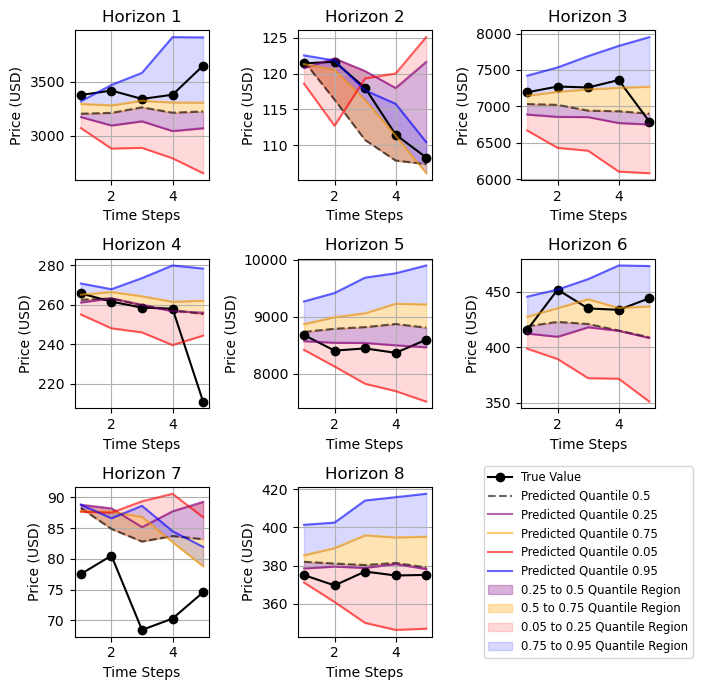

In [18]:
time_steps = list(range(1, output_size + 1))
fig, axs = plt.subplots(3, 3, figsize=(7, 7))
axs = axs.flatten()
for i in range(8):
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, scaler.inverse_transform(results[0.5])[i], linestyle='--', color='black', label='Predicted Quantile 0.5', alpha=0.6)
    ax.plot(time_steps, scaler.inverse_transform(results[0.25])[i], linestyle='-', color='purple', label='Predicted Quantile 0.25', alpha=0.6)
    ax.plot(time_steps, scaler.inverse_transform(results[0.75])[i], linestyle='-', color='orange', label='Predicted Quantile 0.75', alpha=0.6)
    ax.plot(time_steps, scaler.inverse_transform(results[0.05])[i], linestyle='-', color='red', label='Predicted Quantile 0.05', alpha=0.6)
    ax.plot(time_steps, scaler.inverse_transform(results[0.95])[i], linestyle='-', color='blue', label='Predicted Quantile 0.95', alpha=0.6)

    # Highlight regions between quantiles
    ax.fill_between(time_steps, scaler.inverse_transform(results[0.25])[i], scaler.inverse_transform(results[0.5])[i], color='purple', alpha=0.3, label='0.25 to 0.5 Quantile Region')
    ax.fill_between(time_steps, scaler.inverse_transform(results[0.5])[i], scaler.inverse_transform(results[0.75])[i], color='orange', alpha=0.3, label='0.5 to 0.75 Quantile Region')
    ax.fill_between(time_steps, scaler.inverse_transform(results[0.05])[i], scaler.inverse_transform(results[0.25])[i], color='red', alpha=0.15, label='0.05 to 0.25 Quantile Region')
    ax.fill_between(time_steps, scaler.inverse_transform(results[0.75])[i], scaler.inverse_transform(results[0.95])[i], color='blue', alpha=0.15, label='0.75 to 0.95 Quantile Region')

    ax.set_title(f'Horizon {i+1}')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Price (USD)')
    ax.grid(True)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(2))  # Ensure x-axis only displays integers

handles, labels = axs[0].get_legend_handles_labels()

# Remove the 9th subplot
fig.delaxes(axs[8])
# Add legend in the 9th subplot's space
axs[8] = fig.add_subplot(3, 3, 9)
axs[8].axis('off')  # Hide the axes for the legend subplot
axs[8].legend(handles=handles, labels=labels, loc='center', fontsize='small') 


plt.tight_layout()
plt.show()